In [1]:
import random
from copy import deepcopy

In [2]:
STOCK_SIZE = 100

In [3]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

In [4]:
# 1 * w[0] + 2 * w[1] + .... + M * w[M-1]

def calc_solution_value(orders, stocks): 

    leftovers = deepcopy(stocks)
    
    for order in orders:
        for j, leftover_size in enumerate(leftovers):
            if order <= leftover_size:
                leftovers[j] -= order
                break
            elif j == len(leftovers) - 1:
                leftovers.append(STOCK_SIZE)
                leftovers[-1] -= order
                break
    
    leftovers.sort(reverse = True)
    
    pos = None
    for i, leftover in enumerate(leftovers):
        if leftover == STOCK_SIZE:
            pos = i
        else:
            break
    if pos is not None and pos+1 < len(leftovers):
        leftovers = leftovers[pos+1:]
    
    result = 0    
    for i, leftover in enumerate(leftovers):
        result += (i+1) * leftover
    
    return result, len(leftovers)

In [5]:
def make_small_change(orders, num_orders):
    idxs = [i for i in range(num_orders)]
    random_length = random.randrange(1, num_orders)
    chosen = random.sample(idxs, k = random_length)
    for i in range(random_length):
        for j in range(chosen[i] + 1, num_orders):
            if orders[chosen[i]] != orders[j]:
                tmp = orders[chosen[i]]
                orders[chosen[i]] = orders[j]
                orders[j] = tmp
                break
    

In [6]:
def initialize(orders): # l je lista porudzbina tkd ako dobijem 2 od ove velicine i 3 od ove i blabla
    #onda treba sve to u jedan niz
    orders.sort(reverse = True) #nisam sig bas dal l da sortiram

In [7]:
# nk - The number of the ordered small items by the length of l k .
# N - The number of all small items.
# li - The length of the i th ordered item.
# M - The number of all large objects. - moze da ne bude dato u zadatku vec da se izracuna u initialize f-ji
# Lj - The length of the j th large object.
# wj - The trim loss appeared on j th large object.
# Xij - A binary variable which is equal to one if the i th Item is cut from the j th large object and
# zero otherwise.
# wj = Lj − for i in range(N) for j in range(M)(li * xij) - calc trim loss 
# 0 <= wj <= Lj - logicno

# 0 < j < M - materijal koji imamo
# 0 < i < N - broj porucenih 

In [8]:
import math
from matplotlib import pyplot as plt

In [9]:
def simulated_annealing(orders, stocks, num_orders, num_stocks, T):
    stocks.sort(reverse = True)
    solution = deepcopy(orders)
#     initialize(solution)
    value, stocks_used = calc_solution_value(solution, stocks)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used
    a = 0.9
    min_temperature = 1e-3  

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
    
    while T > 1e-3:
        new_solution = deepcopy(solution)
        make_small_change(new_solution, num_orders)
        new_value, new_stocks_used = calc_solution_value(new_solution, stocks)
        
        diff = new_value - value
        if diff < 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
        elif random.random() < (math.e)**((-diff) / T):
                value = new_value
                solution = deepcopy(new_solution)
                stocks_used = new_stocks_used
        T = a * T
        
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
        
    plt.plot(range(ITERS), PLT_VALUES, label='Value')
    plt.legend()
    plt.show()
    
    plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
    plt.legend()
    plt.show()
    
    return best_solution, best_value, best_stocks_used

In [10]:
def calc_num_stocks(orders, num_orders):
    stocks = [STOCK_SIZE]
    num_stock = 1
    for i in range(num_orders):
        for j in range(num_stock):
            if stocks[j] >= orders[i]:
                stocks[j] -= orders[i]
            else:
                if j == (num_stock - 1):
                    num_stock += 1
                    stocks.append(STOCK_SIZE)
                    stocks[num_stock - 1] -= orders[i]
    return num_stock

In [19]:
orders = [20, 30, 50, 10, 5, 5, 80, 35, 25, 40, 8, 12, 33, 27, 20, 90, 10, 90, 2, 3, 4, 1]
random.shuffle(orders)

In [20]:
num_orders = len(orders)
num_stocks = calc_num_stocks(orders, num_orders)
stocks = [100 for i in range(num_stocks)]

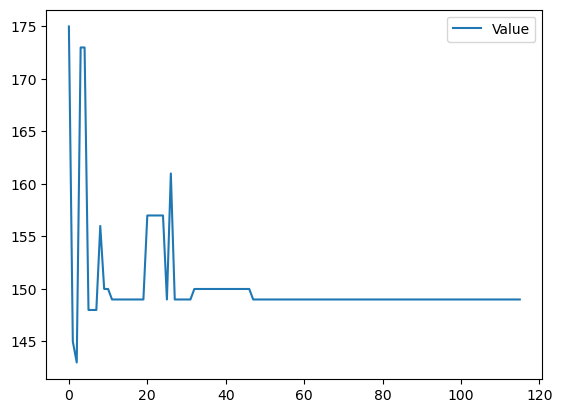

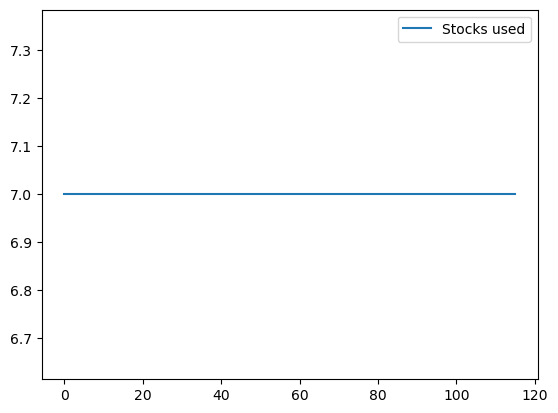

[20, 80, 50, 20, 27, 12, 90, 2, 4, 3, 5, 30, 5, 25, 90, 40, 10, 1, 10, 35, 33, 8] 143 7


In [21]:
solution, value, stocks_used = simulated_annealing(orders, stocks, num_orders, num_stocks, T=200)
print(solution, value, stocks_used)

In [14]:
orders = read_instance('test_instances/test_instance_20.csp')
num_orders = len(orders)
num_stocks = calc_num_stocks(orders, num_orders)
stocks = [100 for i in range(num_stocks)]

In [15]:
num_stocks

752

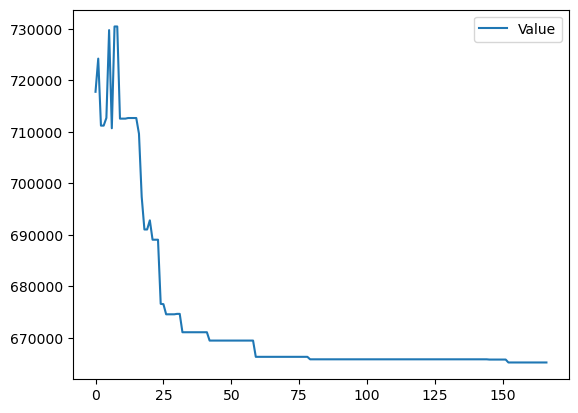

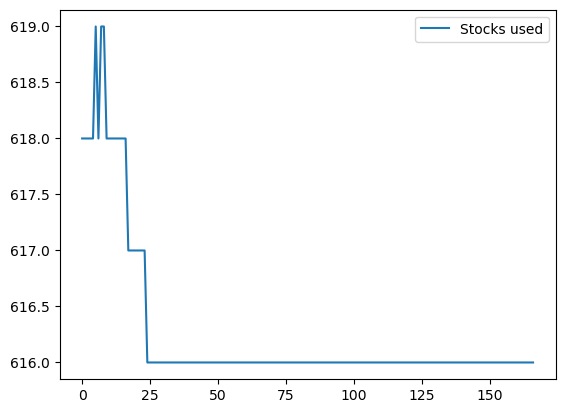

665226 616


In [17]:
solution, value, stocks_used = simulated_annealing(orders, stocks, num_orders, num_stocks, T=40000)
print(value, stocks_used)